# Localization

Predict a single bounding box per image. Uses the MobileNet-based classifier as the starting point.

**NOTE:** The results in this notebook are similar to those shown in the book but are not 100% the same. Because neural networks are initialized with random numbers, each training session will give slightly different results.

## Load the annotations

In [1]:
import sys
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


In [2]:
import os, sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
data_dir = "snacks"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [4]:
train_annotations = pd.read_csv(os.path.join(data_dir, "annotations-train.csv"))
train_annotations.head()

,image_id,x_min,x_max,y_min,y_max,class_name,folder
0,009218ad38ab2010,0.192620,0.729831,0.127606,0.662219,cake,cake
1,009218ad38ab2010,0.802377,1.000000,0.102585,0.405338,ice cream,cake
2,009218ad38ab2010,0.814884,0.970607,0.121768,0.357798,ice cream,cake
3,00c7515143b32051,0.135084,0.904315,0.081735,0.909091,cake,muffin
4,00c7515143b32051,0.155722,0.910569,0.083403,0.893244,muffin,muffin


In [5]:
len(train_annotations)

7040

In [6]:
val_annotations = pd.read_csv(os.path.join(data_dir, "annotations-val.csv"))
test_annotations = pd.read_csv(os.path.join(data_dir, "annotations-test.csv"))

In [7]:
len(val_annotations), len(test_annotations)

(1417, 1380)

## Plot training image + its bounding boxes

In [8]:
image_width = 224
image_height = 224

In [9]:
from helpers import plot_image

Using TensorFlow backend.


In [10]:
from keras.preprocessing import image

def plot_image_from_row(row, image_dir):
    image_path = os.path.join(image_dir, row["folder"], row["image_id"] + ".jpg")
    img = image.load_img(image_path, target_size=(image_width, image_height))
    bbox = (row["x_min"], row["x_max"], row["y_min"], row["y_max"], row["class_name"])
    plot_image(img, [bbox])

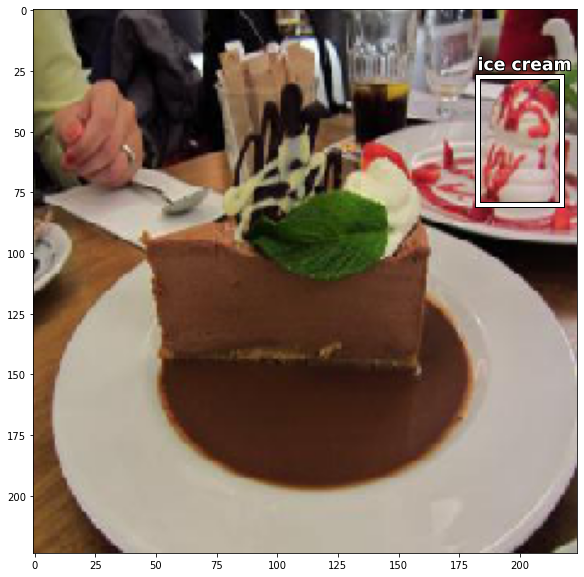

In [11]:
plot_image_from_row(train_annotations.iloc[2], train_dir)

## Custom generator

In [12]:
from helpers import BoundingBoxGenerator

In [13]:
batch_size = 32
train_generator = BoundingBoxGenerator(train_annotations, train_dir, 
                                       image_height, image_width, 
                                       batch_size, shuffle=True)

In [14]:
train_iter = iter(train_generator)
X, (y_class, y_bbox) = next(train_iter)

In [15]:
X.shape, y_class.shape, y_bbox.shape

((32, 224, 224, 3), (32,), (32, 4))

In [16]:
y_bbox

array([[0.036898, 0.986241, 0.165103, 0.868043],
       [0.525328, 0.697936, 0.638503, 0.788235],
       [0.59    , 0.750625, 0.355833, 0.540833],
       [0.      , 1.      , 0.055034, 0.908693],
       [0.196939, 0.616753, 0.001879, 0.348785],
       [0.048155, 0.933083, 0.026689, 0.978315],
       [0.516875, 0.805   , 0.321111, 0.665556],
       [0.116732, 0.35214 , 0.182349, 0.318624],
       [0.157368, 0.937053, 0.161638, 0.974138],
       [0.205754, 0.786742, 0.039585, 0.903864],
       [0.      , 0.999375, 0.106756, 0.964137],
       [0.709375, 0.99375 , 0.029144, 0.454463],
       [0.258841, 0.459182, 0.010719, 1.      ],
       [0.102564, 0.724203, 0.246038, 0.968307],
       [0.388368, 0.424015, 0.70892 , 0.762441],
       [0.      , 0.974449, 0.054375, 0.99125 ],
       [0.013093, 0.898527, 0.08347 , 0.929624],
       [0.489056, 0.684803, 0.359168, 0.582231],
       [0.330206, 0.978111, 0.013344, 0.964137],
       [0.31207 , 0.873046, 0.459734, 0.921032],
       [0.113196, 0.

In [17]:
y_class

array([18,  4, 17, 18, 12, 12, 17, 12, 14, 19,  8, 12,  4,  8,  7,  4,  9,
       17, 10,  1, 15, 18,  1,  8,  0, 11, 16, 17,  8,  5,  3,  6])

In [18]:
from helpers import labels
list(map(lambda x: labels[x], y_class))

['waffle',
 'carrot',
 'strawberry',
 'waffle',
 'orange',
 'orange',
 'strawberry',
 'orange',
 'popcorn',
 'watermelon',
 'hot dog',
 'orange',
 'carrot',
 'hot dog',
 'grape',
 'carrot',
 'ice cream',
 'strawberry',
 'juice',
 'banana',
 'pretzel',
 'waffle',
 'banana',
 'hot dog',
 'apple',
 'muffin',
 'salad',
 'strawberry',
 'hot dog',
 'cookie',
 'candy',
 'doughnut']

In [19]:
len(train_generator)

220

In [20]:
def plot_image_from_batch(X, y_class, y_bbox, img_idx):
    class_name = labels[y_class[img_idx]]
    bbox = y_bbox[img_idx]
    plot_image(X[img_idx], [[*bbox, class_name]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


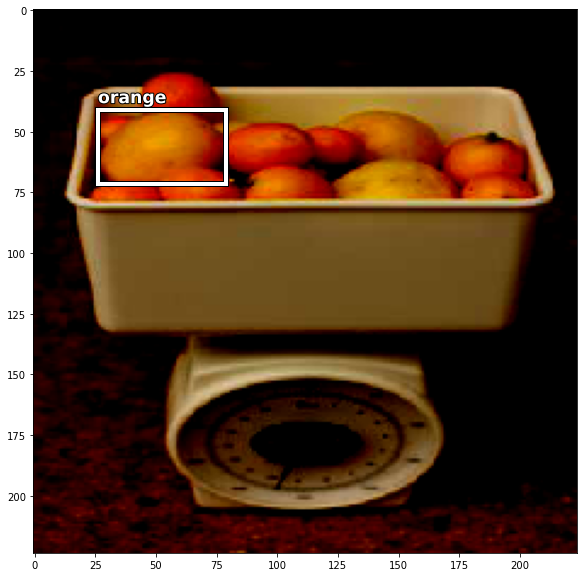

In [21]:
plot_image_from_batch(X, y_class, y_bbox, 7)

In [22]:
X, (y_class, y_bbox) = next(train_iter)

## Load the best model from last time

In [23]:
import keras
from keras.models import Sequential
from keras.layers import *
from keras.models import Model, load_model
from keras import optimizers, callbacks
import keras.backend as K
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
 
KTF.set_session(tf.Session(config=tf.ConfigProto(device_count={'gpu':0})))

classifier_model = load_model("checkpoints/multisnacks-0.7162-0.8419.hdf5")







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
classifier_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                20500     
_________________________________________________________________
activation_3 (Activation)    (None, 20)                0         
Total params: 3,249,364
Trainable params: 3,227,476
Non-trainable params: 21,888
_________________________________________________________________


## Add the bounding box predictor to the model

In [25]:
num_classes = 20

# The MobileNet feature extractor is the first "layer".
base_model = classifier_model.layers[0]

# Add a global average pooling layer after MobileNet.
pool = GlobalAveragePooling2D()(base_model.outputs[0])

# Reconstruct the classifier layers.
clf = Dropout(0.7)(pool)
clf = Dense(num_classes, kernel_regularizer=keras.regularizers.l2(0.01), name="dense_class")(clf)
clf = Activation("softmax", name="class_prediction")(clf)

# Add new layers for the bounding box predictor.
bbox = Conv2D(512, 3, padding="same")(base_model.outputs[0])
bbox = BatchNormalization()(bbox)
bbox = Activation("relu")(bbox)
bbox = GlobalAveragePooling2D()(bbox)
bbox = Dense(4, name="bbox_prediction")(bbox)

# Create the new model.
model = Model(inputs=base_model.inputs, outputs=[clf, bbox])

In [26]:
for layer in base_model.layers:
    layer.trainable = False

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

Put the old weights back, or the classifier won't work anymore:

In [28]:
layer_dict = {layer.name:i for i, layer in enumerate(model.layers)}

# Get the weights from the checkpoint model.
weights, biases = classifier_model.layers[-2].get_weights()

# Put them into the new model.
model.layers[layer_dict["dense_class"]].set_weights([weights, biases])

In [29]:
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[1.0, 10.0],
              optimizer=optimizers.Adam(lr=1e-3),
              metrics={ "class_prediction": "accuracy" })

## Try the model on an image

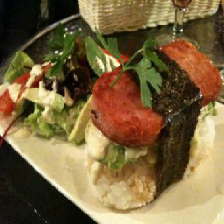

In [30]:
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image

img = image.load_img(train_dir + "/salad/2ad03070c5900aac.jpg", target_size=(image_width, image_height))
img

In [31]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [32]:
preds = model.predict(x)
preds

[array([[5.5659082e-05, 7.1897813e-07, 7.4317250e-05, 4.5375164e-06,
         2.9821682e-04, 2.9114778e-06, 5.2616288e-06, 4.8986397e-04,
         6.5828249e-04, 6.8758155e-04, 3.6887937e-05, 6.2949434e-06,
         1.6075590e-05, 2.1348683e-04, 1.9503818e-06, 8.5053324e-07,
         9.7398055e-01, 2.2265238e-03, 1.5832029e-03, 1.9656979e-02]],
       dtype=float32),
 array([[0.25206026, 1.6441703 , 1.8208144 , 0.38256803]], dtype=float32)]

In [33]:
len(preds)

2

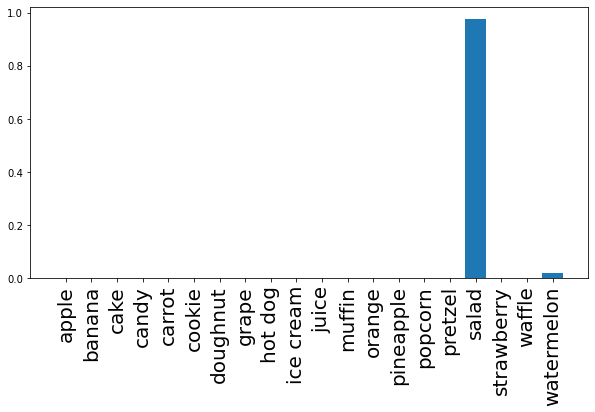

In [34]:
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), preds[0].squeeze())
plt.xticks(range(num_classes), labels, rotation=90, fontsize=20)
plt.show()

In [35]:
preds = classifier_model.predict(x)
preds

array([[5.5659082e-05, 7.1897813e-07, 7.4317250e-05, 4.5375164e-06,
        2.9821682e-04, 2.9114778e-06, 5.2616288e-06, 4.8986397e-04,
        6.5828249e-04, 6.8758155e-04, 3.6887937e-05, 6.2949434e-06,
        1.6075590e-05, 2.1348683e-04, 1.9503818e-06, 8.5053324e-07,
        9.7398055e-01, 2.2265238e-03, 1.5832029e-03, 1.9656979e-02]],
      dtype=float32)

In [36]:
preds = model.predict_generator(train_generator)

In [37]:
preds[1].shape

(7040, 4)

## Train the model

In [38]:
val_generator = BoundingBoxGenerator(val_annotations, val_dir, 
                                     image_height, image_width, 
                                     batch_size, shuffle=False)

In [39]:
from helpers import combine_histories, plot_loss, plot_bbox_loss

In [40]:
histories = []

In [41]:
histories.append(model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_generator),
                                     epochs=5,
                                     validation_data=val_generator,
                                     validation_steps=len(val_generator),
                                     workers=8))

Epoch 1/5
220/220 [==============================] - 16s 73ms/step - loss: 1.9999 - class_prediction_loss: 0.4643 - bbox_prediction_loss: 0.1389 - class_prediction_acc: 0.8729 - val_loss: 1.2262 - val_class_prediction_loss: 0.5794 - val_bbox_prediction_loss: 0.0498 - val_class_prediction_acc: 0.8246
Epoch 2/5
220/220 [==============================] - 15s 67ms/step - loss: 0.9523 - class_prediction_loss: 0.4329 - bbox_prediction_loss: 0.0370 - class_prediction_acc: 0.8774 - val_loss: 1.1964 - val_class_prediction_loss: 0.5970 - val_bbox_prediction_loss: 0.0449 - val_class_prediction_acc: 0.8281
Epoch 3/5
220/220 [==============================] - 15s 67ms/step - loss: 0.9086 - class_prediction_loss: 0.4236 - bbox_prediction_loss: 0.0332 - class_prediction_acc: 0.8749 - val_loss: 1.1642 - val_class_prediction_loss: 0.5925 - val_bbox_prediction_loss: 0.0418 - val_class_prediction_acc: 0.8288
Epoch 4/5
220/220 [==============================] - 15s 67ms/step - loss: 0.8878 - class_predict

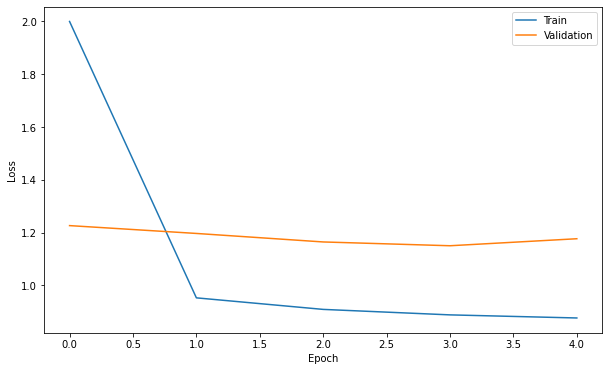

In [42]:
history = combine_histories(histories)
plot_loss(history)

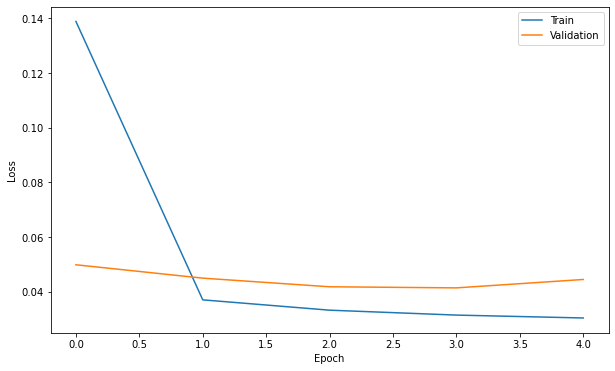

In [43]:
plot_bbox_loss(history)

## Try the model on the test set

In [44]:
def plot_prediction(row, image_dir):
    image_path = os.path.join(image_dir, row["folder"], row["image_id"] + ".jpg")
    img = image.load_img(image_path, target_size=(image_width, image_height))
    bbox_true = [row["x_min"], row["x_max"], row["y_min"], row["y_max"], row["class_name"].upper()]
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = model.predict(x)
    bbox_pred = [*pred[1][0], labels[np.argmax(pred[0])]]
    
    plot_image(img, [bbox_true, bbox_pred])
   

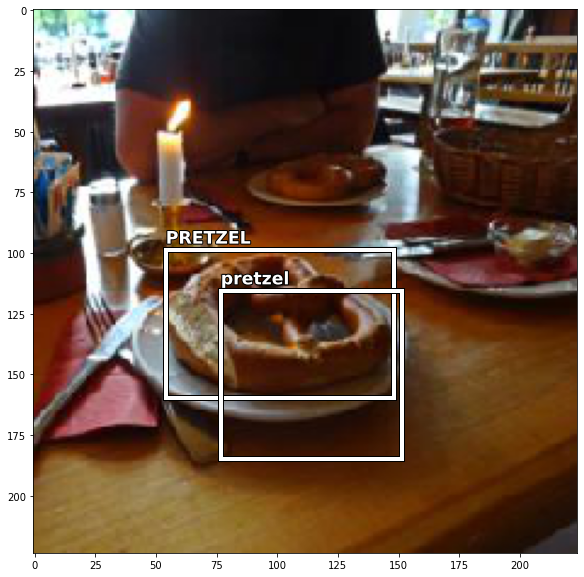

In [45]:
row_index = np.random.randint(len(test_annotations))
row = test_annotations.iloc[row_index]
plot_prediction(row, test_dir)

## Convert to mlmodel

In [46]:
import coremltools

In [47]:
coreml_model = coremltools.converters.keras.convert(model, input_names='image', image_input_names='image', 
    red_bias=-1, green_bias=-1, blue_bias=-1, image_scale=2/255.0)

0 : input_3, <keras.engine.input_layer.InputLayer object at 0x7f85ec0b1748>
1 : conv1_pad, <keras.layers.convolutional.ZeroPadding2D object at 0x7f85ec0b17b8>
2 : conv1, <keras.layers.convolutional.Conv2D object at 0x7f85ec0b1828>
3 : conv1_bn, <keras.layers.normalization.BatchNormalization object at 0x7f85ec0b18d0>
4 : conv1_relu, <keras.layers.advanced_activations.ReLU object at 0x7f85ec0b1ac8>
5 : conv_dw_1, <keras.layers.convolutional.DepthwiseConv2D object at 0x7f85ec0b1cc0>
6 : conv_dw_1_bn, <keras.layers.normalization.BatchNormalization object at 0x7f85ec0b1cf8>
7 : conv_dw_1_relu, <keras.layers.advanced_activations.ReLU object at 0x7f85ec0b1d68>
8 : conv_pw_1, <keras.layers.convolutional.Conv2D object at 0x7f85ec0cc0b8>
9 : conv_pw_1_bn, <keras.layers.normalization.BatchNormalization object at 0x7f85ec0cc240>
10 : conv_pw_1_relu, <keras.layers.advanced_activations.ReLU object at 0x7f85ec0cc358>
11 : conv_pad_2, <keras.layers.convolutional.ZeroPadding2D object at 0x7f85ec0cc390>

In [48]:
coreml_model.save('./SnackLocalization.mlmodel')